# Mapping Overdose Vulnerability
## Andy Asher, NWMSU
### https://github.com/andyakiva/capstone

Import the cleaned data and the needed packages

In [8]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

csv = r'C:\Users\Andy\Documents\OverdoseAnalysis\ReadyData.csv'
data = pd.read_csv(csv)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Zip Code                           48 non-null     int64  
 1   Males Widowed                      48 non-null     float64
 2   Males Divorced                     48 non-null     float64
 3   Females Widowed                    48 non-null     float64
 4   Females Divorced                   48 non-null     float64
 5   High school graduate or higher     48 non-null     float64
 6   Bachelor's degree or higher        48 non-null     float64
 7   Civilian veterans                  48 non-null     float64
 8   With a disability                  48 non-null     float64
 9   Unemployment Rate                  48 non-null     float64
 10  With health insurance coverage     48 non-null     float64
 11   With private health insurance     48 non-null     float64
 

Define Column Names

In [9]:
data.columns = ["Zip Code", "Males Widowed", "Males Divorced", "Females Widowed", "Females Divorced", "High school graduate or higher", 
                "Bachelor's degree or higher", "Civilian veterans", "With a disability", "Unemployment Rate", "With health insurance coverage",
                "With private health insurance", "With public coverage", "No health insurance coverage",
                "Percent People in Poverty", "Median household income (dollars)", "Mean household income (dollars)", "FATAL OVERDOSE BY ZIP CODE","Males 15 Years and Over", "Females 15 Years and Over"]
data = data.set_index("Zip Code")


Convert Overdose Count to Rate Per Capita

In [10]:
data["Overdose per capita"] = data["FATAL OVERDOSE BY ZIP CODE"] / ((data["Males 15 Years and Over"]+ data["Females 15 Years and Over"])/1000)
overdoses = "Overdose per capita"

Preliminary Visualizations

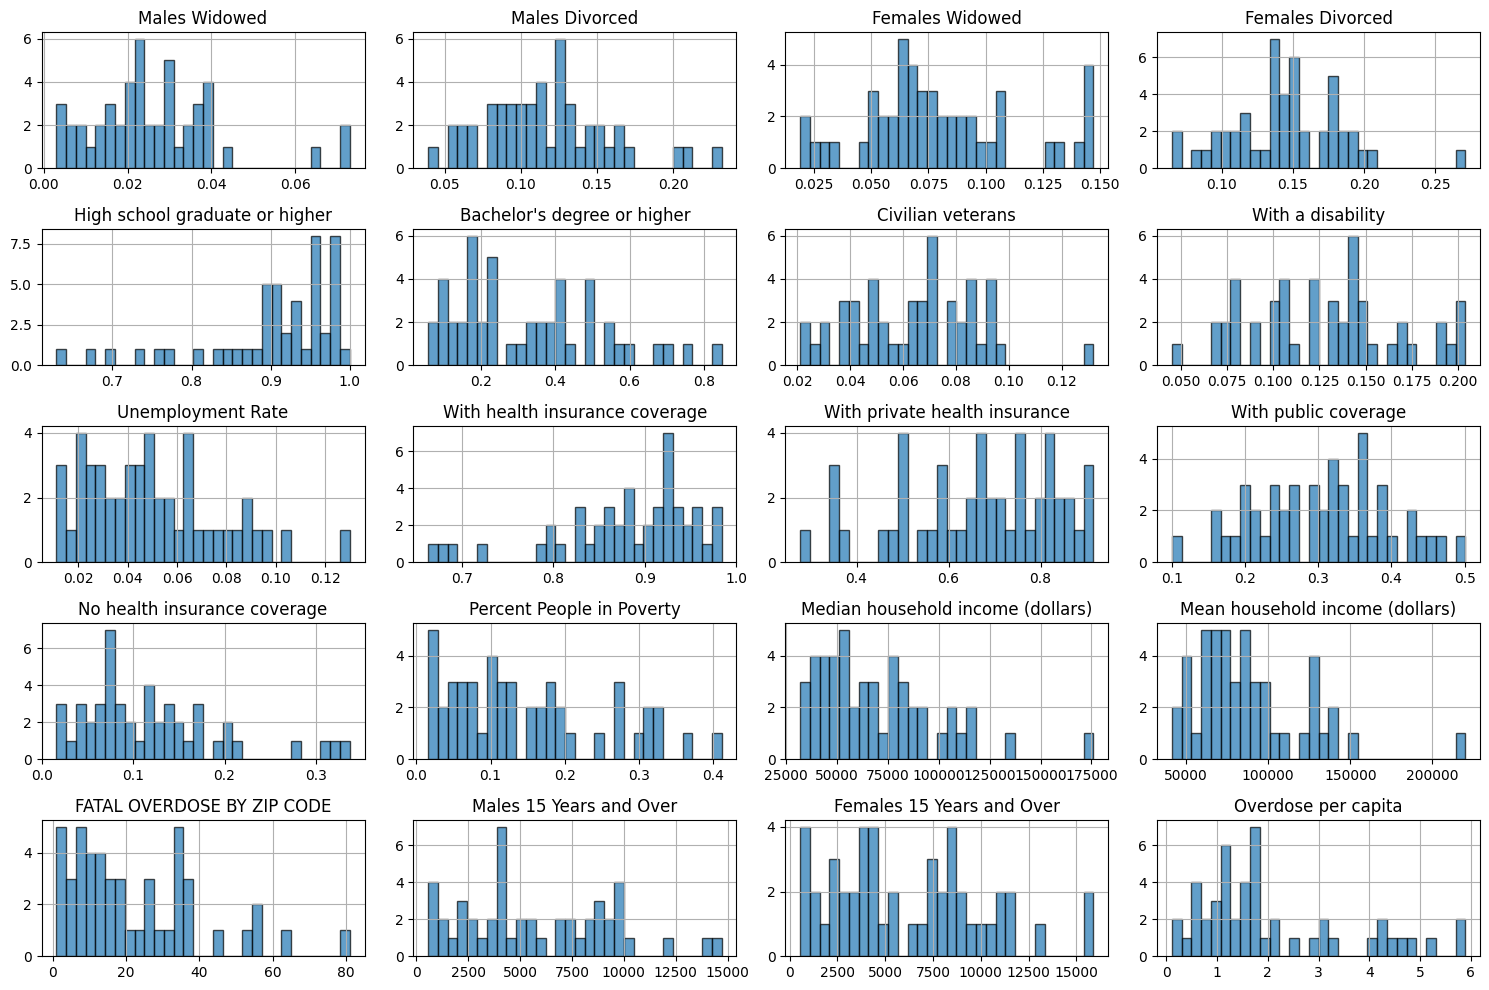

In [11]:
data.hist(figsize=(15, 10), bins=30, edgecolor='k', alpha=0.7)
plt.tight_layout()
plt.show()

Initial Correlation Overview

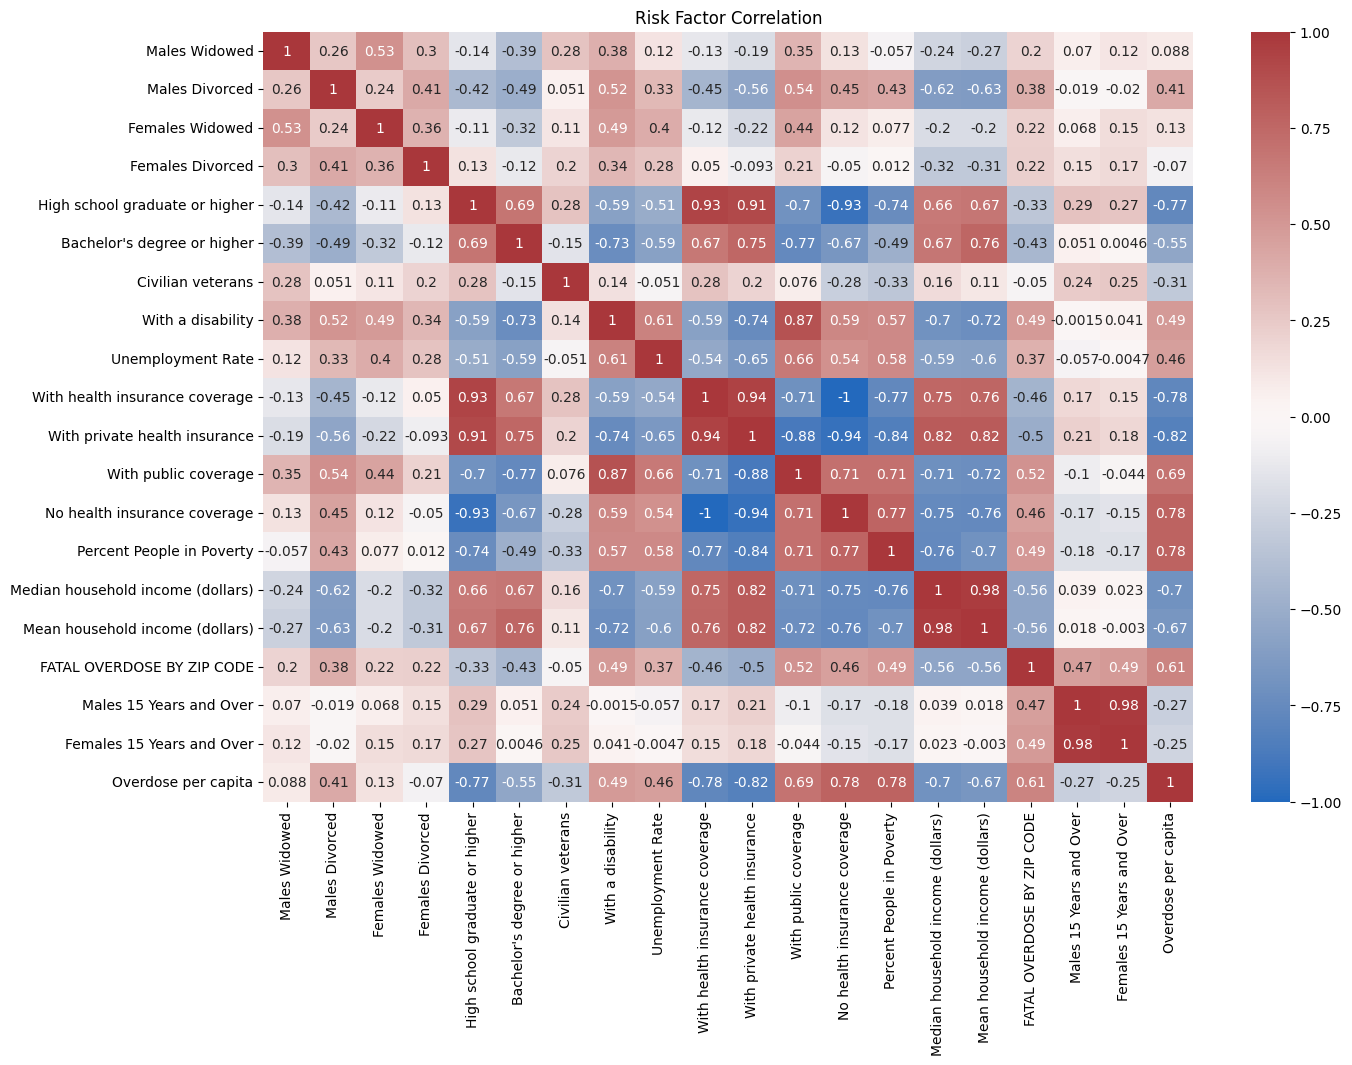

In [12]:
correlation = data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, annot=True, cmap="vlag")
plt.title('Risk Factor Correlation')
plt.show()

## ML 

Train Test Split

In [13]:
train_set, test_set = train_test_split(data,
 test_size=0.2, random_state=123)
print('Train size: ', len(train_set), 'Test size: ', len(test_set))

Train size:  38 Test size:  10


Determine which individual factors have the highest predictive value 

Use the factors with the highest individual value to find the best number of factors to include

In [24]:
#run the regressions
power = 3
poly_process = PolynomialFeatures(degree=power, include_bias=False)

regressions = {}
for stop in range (1,21):
    tested = orderedfactorlist[0:stop]
    X = train_set[tested]
    y = train_set[overdoses]
    X_poly = poly_process.fit_transform(X)
    X_test = test_set[tested]
    y_test = test_set[overdoses]
    X_poly_test = poly_process.fit_transform(X_test)
    lr_model = LinearRegression()
    lr_model.fit(X_poly,y)
    y_pred = lr_model.predict(X_poly)
    y_test_pred = lr_model.predict(X_poly_test) 
    predictivevalue = r2_score(y_test,y_test_pred)
    if 1 > predictivevalue > 0:
        regressions[stop] = (r2_score(y_test,y_test_pred))
        print(tested)
        print(stop,r2_score(y_test,y_test_pred) )
print(regressions)

['Mean household income (dollars)']
1 0.5166005665106916
['Mean household income (dollars)', 'Median household income (dollars)']
2 0.20985712936704748
['Mean household income (dollars)', 'Median household income (dollars)', 'Civilian veterans']
3 0.5677618485275313
['Mean household income (dollars)', 'Median household income (dollars)', 'Civilian veterans', 'With private health insurance']
4 0.39777967165656647
{1: 0.5166005665106916, 2: 0.20985712936704748, 3: 0.5677618485275313, 4: 0.39777967165656647}


In [25]:
#puts the score first, stop second
scorefirst = {}
for stop in regressions:
    scorefirst[regressions[stop]] = stop

#orders the pairs by score
scoresordered = {}
hold = list(scorefirst.keys())
hold.sort(reverse = True)
for h in hold:
    scoresordered[h] = scorefirst[h]

#list of stops, in order by regression fit
stopsordered = list(scoresordered.values())
print(stopsordered)

[3, 1, 4, 2]


In [26]:
#create a variable that is the factors used for the regression that fits best
bestfactors = list()
beststop = stopsordered[0]
for factor in orderedfactorlist[0:beststop]:
    bestfactors.append(factor)
print(bestfactors)

    

['Mean household income (dollars)', 'Median household income (dollars)', 'Civilian veterans']


In [27]:
X = train_set[bestfactors]
y = train_set[overdoses]
X_poly = poly_process.fit_transform(X)
X_test = test_set[bestfactors]
y_test = test_set[overdoses]
X_poly_test = poly_process.fit_transform(X_test)
lr_model = LinearRegression()
lr_model.fit(X_poly,y)
y_pred = lr_model.predict(X_poly)
print('Results for polynomial regression on training data')
print(' Default settings')
print('Internal parameters:')
print(' Bias is ', lr_model.intercept_)
print(' Coefficients', lr_model.coef_)

print('MAE is ', mean_absolute_error(y, y_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y, y_pred)))
print('MSE is ', mean_squared_error(y, y_pred))
print('R^2 ', r2_score(y,y_pred))
y_test_pred = lr_model.predict(X_poly_test)
print()
print('Results for polynomial regression on test data')
print('MAE is ', mean_absolute_error(y_test, y_test_pred))
print('RMSE is ', np.sqrt(mean_squared_error(y_test,
y_test_pred)))
print('MSE is ', mean_squared_error(y_test, y_test_pred))
print('R^2 ', r2_score(y_test,y_test_pred))

Results for polynomial regression on training data
 Default settings
Internal parameters:
 Bias is  13.420999519727804
 Coefficients [ 5.05616991e-04 -9.95911091e-04 -6.41182194e-07 -1.77703756e-09
 -4.54877876e-09 -2.22353277e-03  1.18521707e-08  2.83691219e-03
 -2.87281361e-06 -1.33644714e-13  5.45454106e-13 -6.29013566e-09
 -7.01971488e-13  7.35348430e-08 -3.00262636e-02  2.76303385e-13
 -8.24940509e-08  3.72059005e-02 -3.27066602e-07]
MAE is  0.43152798776043255
RMSE is  0.5369142558114789
MSE is  0.28827691809359424
R^2  0.8872132050914155

Results for polynomial regression on test data
MAE is  0.526068188017992
RMSE is  0.6845385148744892
MSE is  0.46859297834657127
R^2  0.5677618485275313
